In [46]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# Lag stivariabler
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/NIST'


%pwd
path = "data/NIST/"
%pwd


u'/data/Kurs_nabla_timini'

In [4]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [7]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [8]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [9]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [15]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [12]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [61]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [62]:
model = VGG_16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [63]:
FILES_PATH = 'http://files.fast.ai/models/';
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

#classes = ['glasses', 'suits']

In [64]:
batch_size = 64

In [65]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [66]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [67]:
def ft(model, num):
    """
        Replace the last layer of the model with a Dense (fully connected) layer of num neurons.
        Will also lock the weights of all layers except the new layer so that we only learn
        weights for the last layer in subsequent training.

        Args:
            num (int) : Number of neurons in the Dense layer
        Returns:
            None
    """
    model.pop()
    for layer in model.layers: layer.trainable=False
    model.add(Dense(num, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0001),
                loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
def finetune(model, batches):
    """
        Modifies the original VGG16 network architecture and updates self.classes for new training data.

        Args:
            batches : A keras.preprocessing.image.ImageDataGenerator object.
                      See definition for get_batches().
    """
    ft(model,batches.nb_class)
    classes = list(iter(batches.class_indices)) # get a list of all the class labels

    # batches.class_indices is a dict with the class name as key and an index as value
    # eg. {'cats': 0, 'dogs': 1}

    # sort the class labels by index according to batches.class_indices and update model.classes
    for c in batches.class_indices:
        classes[batches.class_indices[c]] = c
    model.classes = classes

In [70]:
def fit(model, batches, val_batches, nb_epoch=1):
    """
        Fits the model on data yielded batch-by-batch by a Python generator.
        See Keras documentation: https://keras.io/models/model/
    """
    model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
            validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Found 2311 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


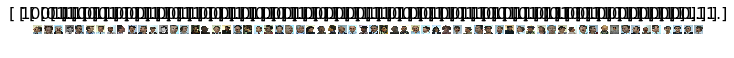

In [71]:
batches = get_batches('train', batch_size=6)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

In [72]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
finetune(model,batches)
fit(model, batches, val_batches, nb_epoch=1)

Found 2311 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/1
2311/2311 [==============================] - 101s - loss: 1.0473 - acc: 0.5915 - val_loss: 0.4419 - val_acc: 0.7700


In [73]:
    def predict(model, imgs, details=False):
        """
            Predict the labels of a set of images using the VGG16 model.

            Args:
                imgs (ndarray)    : An array of N images (size: N x width x height x channels).
                details : ??
            
            Returns:
                preds (np.array) : Highest confidence value of the predictions for each image.
                idxs (np.ndarray): Class index of the predictions with the max confidence.
                classes (list)   : Class labels of the predictions with the max confidence.
        """
        # predict probability of each class for each image
        all_preds = model.predict(imgs)
        # for each image get the index of the class with max probability
        idxs = np.argmax(all_preds, axis=1)
        # get the values of the highest probability for each image
        preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
        # get the label of the class with the highest probability for each image
        classes = [model.classes[idx] for idx in idxs]
        return np.array(preds), idxs, classes

Found 15 images belonging to 1 classes.


(array([ 0.81402361,  0.90242559,  0.85660011,  0.98396087,  0.83989125,
         0.95465046], dtype=float32),
 array([1, 0, 0, 1, 0, 0]),
 ['suits', 'glasses', 'glasses', 'suits', 'glasses', 'glasses'])

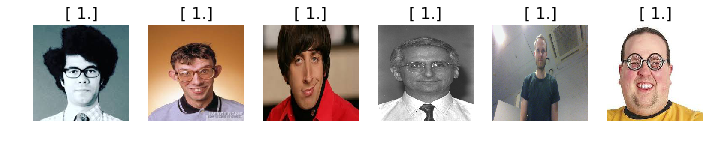

In [75]:
# Prediker på våre testdata
batches = get_batches('test', batch_size=6)
imgs,labels = next(batches)

plots(imgs, titles=labels)

predict(model, imgs, True)